In [15]:
import numpy as np
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,concatenate,Dropout, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import model_from_json
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras.callbacks import History
import data
import pickle
import cv2
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last') #input shape = 32,32,3 instead of 3,32,32
K.set_learning_phase(1)


In [3]:
#for gpu tensorflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
def load_train(path_to_folder,batch_id):
    with open(path_to_folder + "/data_batch_"  + str(batch_id), 'rb') as file:
        train = pickle.load(file,encoding='latin1')
    X_train_orig = train['data'].reshape(len(train['data']),3,32,32).transpose(0,2,3,1) 
    Y_train_orig = train['labels']
    return X_train_orig,Y_train_orig

In [5]:
def load_test(path_to_folder):
    with open(path_to_folder + "/test_batch", 'rb') as file:
        test = pickle.load(file,encoding='latin1')
    X_test_orig = test['data'].reshape(len(test['data']),3,32,32).transpose(0,2,3,1) 
    Y_test_orig = test['labels']
    return X_test_orig,Y_test_orig

In [6]:
def load_meta(path_to_folder = 'cifar-10-python'):
    with open(path_to_folder + "/batches.meta", 'rb') as file:
        meta = pickle.load(file,encoding='latin1')
        classes = meta['label_names']
        num_of_cases_per_batch = meta['num_cases_per_batch']
    return num_of_cases_per_batch,classes

In [7]:
def one_hot_encode(Y):
    encoded = np.zeros((len(Y),len(set(Y))))
    for idx,val in enumerate(Y):
        encoded[idx,val] = 1 
    return encoded

In [8]:
def load_data():
    path_to_folder = 'cifar-10-python'
    num_of_batchs = 5
    batch_id = 1
    #combine batches into 1 batch
    X_train_orig = []
    Y_train_orig = []
    for i in range(1,num_of_batchs+1):
        X_batch,Y_batch = data.load_train(i,path_to_folder)
        X_train_orig.extend(X_batch)
        Y_train_orig.extend(Y_batch)

    X_test_orig,Y_test_orig = data.load_test(path_to_folder)
    X_train_orig = np.array(X_train_orig)
    Y_train_orig = np.array(Y_train_orig)

    #split data
    X_train_orig, X_val_orig, Y_train_orig, Y_val_orig = train_test_split(X_train_orig, Y_train_orig, test_size=0.1, random_state=12345)
    X_train = X_train_orig / 255
    X_test= X_test_orig / 255
    X_val = X_val_orig / 255

    Y_train = data.one_hot_encode(Y_train_orig)
    Y_test = data.one_hot_encode(Y_test_orig)
    Y_val = data.one_hot_encode(Y_val_orig)
    _,classes = data.load_meta(path_to_folder)
    return X_train,Y_train ,X_val,Y_val,X_test,Y_test,X_train_orig, X_val_orig, Y_train_orig, Y_val_orig,X_test_orig,Y_test_orig,classes

In [9]:
X_train,Y_train ,X_val,Y_val,X_test,Y_test,X_train_orig, X_val_orig,Y_train_orig, Y_val_orig,X_test_orig,Y_test_orig,classes = load_data()

In [10]:
#shapes
print("Number of training examples :",X_train.shape[0])
print("Number of testing examples :",X_test.shape[0])
print("X Train shape :",X_train.shape)
print("Y Train shape :",Y_train.shape)
print("X test shape :",X_test.shape)
print("Y Test shape :",Y_test.shape)
print("X Validation shape :",X_val.shape)
print("Y Validation shape :",Y_val.shape)
print("classes are :",classes)

Number of training examples : 45000
Number of testing examples : 10000
X Train shape : (45000, 32, 32, 3)
Y Train shape : (45000, 10)
X test shape : (10000, 32, 32, 3)
Y Test shape : (10000, 10)
X Validation shape : (5000, 32, 32, 3)
Y Validation shape : (5000, 10)
classes are : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Text(0.5, 1.0, 'dog')

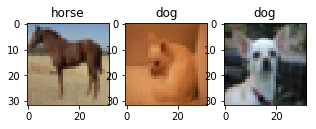

In [53]:
plt.figure(figsize=(5,5))
plt.subplot(1,3,1)
plt.imshow(X_train_orig[1290])
plt.title(classes[Y_train_orig[1290]])
plt.subplot(1,3,2)
plt.imshow(X_val_orig[1290])
plt.title(classes[Y_val_orig[1290]])
plt.subplot(1,3,3)
plt.imshow(X_test_orig[1290])
plt.title(classes[Y_test_orig[1290]])

# Histogram:

 data is balanced in each class in training data.

 each class has 5k examples
 
 * as data is balanced in each class we'll use accuracy as a materic else we'll use F1 score

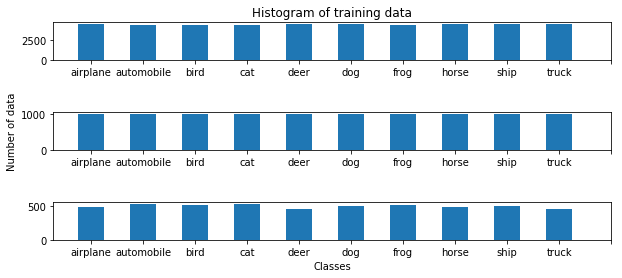

In [10]:
fig = plt.figure(figsize=(10,4))
ax = plt.subplot(511)
#training data
ax.hist(Y_train_orig,bins=np.arange(11),histtype='bar',rwidth=0.5,align='left')
ax.set_title("Histogram of training data")
ax.set_xticks(np.arange(11))
ax.set_xticklabels(classes)
#testing data
ax = plt.subplot(513)
ax.hist(Y_test_orig,bins=np.arange(11),histtype='bar',rwidth=0.5,align='left')
ax.set_ylabel("Number of data")
ax.set_xticks(np.arange(11))
ax.set_xticklabels(classes)
#validation data
ax = plt.subplot(515)
ax.hist(Y_val_orig,bins=np.arange(11),histtype='bar',rwidth=0.5,align='left')
ax.set_xlabel("Classes")
ax.set_xticks(np.arange(11))
ax.set_xticklabels(classes)
plt.show()

# You cannot use any function inside this notebook in model or data functions You could put all functions you need to use in model,data functions outside in python file and import it like in data file i used lr_schedule

# never use BatchNormzalization before last activation function(Softmax),
# then All your predicted new images will be wrong labeled even if acc is high at train,test,val data 

In [31]:
#Model_v1 --> Inception Module
def Model_v1(X_train,Y_train,X_val,Y_val):
    batch_size = 64
    learning_rate=0.001
    num_epochs = 20
    steps_per_epoch = X_train.shape[0] // batch_size
    activation='elu'
    weight_decay = 1e-4
    classes=10
    X_input = Input((32,32,3))
    tower_one = MaxPooling2D((3,3), strides=(1,1), padding='same')(X_input)
    tower_one = Conv2D(6, (1,1), activation='relu', border_mode='same')(tower_one)

    tower_two = Conv2D(6, (1,1), activation='relu', border_mode='same')(X_input)
    tower_two = Conv2D(6, (3,3), activation='relu', border_mode='same')(tower_two)

    tower_three = Conv2D(6, (1,1), activation='relu', border_mode='same')(X_input)
    tower_three = Conv2D(6, (5,5), activation='relu', border_mode='same')(tower_three)
    x = concatenate([tower_one, tower_two, tower_three], axis=3)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs = X_input, outputs = x)
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.rmsprop(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=2,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [32]:
model_v1 = Model_v1(X_train,Y_train,X_test,Y_test)

c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  if sys.path[0] == '':
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras

Epoch 1/20
 - 20s - loss: 1.8202 - acc: 0.3565 - val_loss: 1.6326 - val_acc: 0.4314
Epoch 2/20
 - 19s - loss: 1.5353 - acc: 0.4563 - val_loss: 1.4003 - val_acc: 0.5180
Epoch 3/20
 - 20s - loss: 1.4382 - acc: 0.4902 - val_loss: 1.3286 - val_acc: 0.5307
Epoch 4/20
 - 20s - loss: 1.3840 - acc: 0.5080 - val_loss: 1.2744 - val_acc: 0.5530
Epoch 5/20
 - 20s - loss: 1.3532 - acc: 0.5233 - val_loss: 1.2713 - val_acc: 0.5587
Epoch 6/20
 - 19s - loss: 1.3332 - acc: 0.5280 - val_loss: 1.2468 - val_acc: 0.5635
Epoch 7/20
 - 19s - loss: 1.3106 - acc: 0.5379 - val_loss: 1.1999 - val_acc: 0.5801
Epoch 8/20
 - 19s - loss: 1.2913 - acc: 0.5443 - val_loss: 1.1945 - val_acc: 0.5783
Epoch 9/20
 - 19s - loss: 1.2750 - acc: 0.5490 - val_loss: 1.2478 - val_acc: 0.5654
Epoch 10/20
 - 19s - loss: 1.2592 - acc: 0.5562 - val_loss: 1.1693 - val_acc: 0.5928
Epoch 11/20
 - 20s - loss: 1.2524 - acc: 0.5577 - val_loss: 1.1476 - val_acc: 0.5986
Epoch 12/20
 - 21s - loss: 1.2413 - acc: 0.5613 - val_loss: 1.1441 - val_a

In [28]:
#Model_v2 --> Inception Module V1
def Model_v2(X_train,Y_train,X_val,Y_val):
    batch_size = 64
    learning_rate=0.001
    num_epochs = 20
    steps_per_epoch = X_train.shape[0] // batch_size
    weight_decay = 1e-4
    classes=10
    X_input = Input((32,32,3))
    tower_one = MaxPooling2D((3,3), strides=(1,1), padding='same')(X_input)
    tower_one = Conv2D(6, (1,1), activation='relu', border_mode='same')(tower_one)

    tower_two = Conv2D(6, (1,1), activation='relu', border_mode='same')(X_input)
    tower_two = Conv2D(6, (3,3), activation='relu', border_mode='same')(tower_two)

    tower_three = Conv2D(6, (1,1), activation='relu', border_mode='same')(X_input)
    tower_three = Conv2D(6, (3,3), activation='relu', border_mode='same')(tower_three)
    tower_three = Conv2D(6, (3,3), activation='relu', border_mode='same')(tower_three)
    x = concatenate([tower_one, tower_two, tower_three], axis=3)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs = X_input, outputs = x)
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.rmsprop(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=2,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [29]:
model_v2 = Model_v2(X_train,Y_train,X_test,Y_test)

c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  del sys.path[0]
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), activation="relu", padding="same")`
  
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (1, 1), activation="relu", padding="same")`
  app.launch_new_instance()
c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning:

Epoch 1/20
 - 19s - loss: 1.8582 - acc: 0.3459 - val_loss: 1.5469 - val_acc: 0.4525
Epoch 2/20
 - 20s - loss: 1.5218 - acc: 0.4564 - val_loss: 1.4439 - val_acc: 0.4925
Epoch 3/20
 - 19s - loss: 1.4408 - acc: 0.4872 - val_loss: 1.4353 - val_acc: 0.5013
Epoch 4/20
 - 19s - loss: 1.3928 - acc: 0.5035 - val_loss: 1.2697 - val_acc: 0.5487
Epoch 5/20
 - 19s - loss: 1.3519 - acc: 0.5168 - val_loss: 1.3428 - val_acc: 0.5371
Epoch 6/20
 - 19s - loss: 1.3206 - acc: 0.5292 - val_loss: 1.2404 - val_acc: 0.5622
Epoch 7/20
 - 20s - loss: 1.2944 - acc: 0.5406 - val_loss: 1.1435 - val_acc: 0.5944
Epoch 8/20
 - 20s - loss: 1.2746 - acc: 0.5504 - val_loss: 1.2930 - val_acc: 0.5591
Epoch 9/20
 - 19s - loss: 1.2591 - acc: 0.5570 - val_loss: 1.2286 - val_acc: 0.5703
Epoch 10/20
 - 19s - loss: 1.2433 - acc: 0.5593 - val_loss: 1.1192 - val_acc: 0.6032
Epoch 11/20
 - 19s - loss: 1.2308 - acc: 0.5640 - val_loss: 1.1430 - val_acc: 0.6058
Epoch 12/20
 - 20s - loss: 1.2134 - acc: 0.5704 - val_loss: 1.1121 - val_a

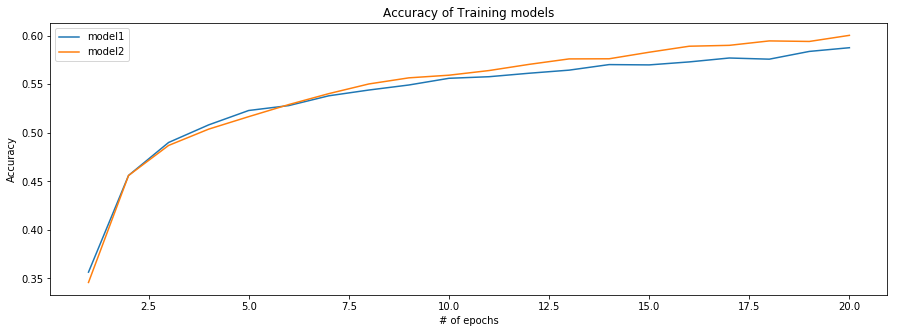

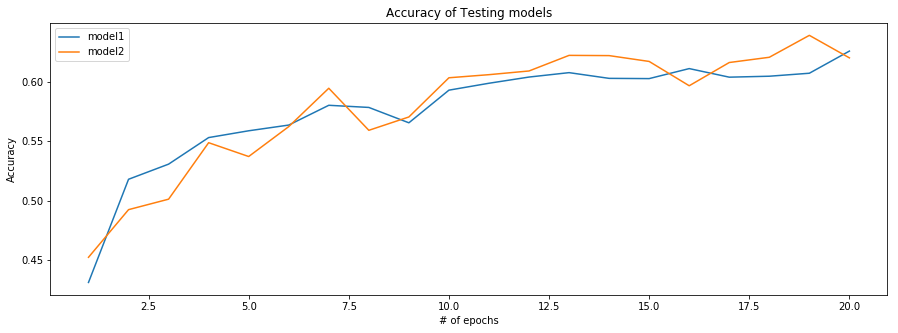

In [34]:
model_v1_train = model_v1['model'].history.history['acc']
model_v1_test = model_v1['model'].history.history['val_acc']
model_v2_train = model_v2['model'].history.history['acc']
model_v2_test = model_v2['model'].history.history['val_acc']

num_of_epochs = 20
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
ax1.set_title("Accuracy of Training models")
ax1.set_xlabel('# of epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(np.arange(1,num_of_epochs+1),model_v1_train)
ax1.plot(np.arange(1,num_of_epochs+1),model_v2_train)
ax1.legend(['model1','model2'])
plt.show()

fig = plt.figure(figsize=(15,5))
ax2 = plt.subplot(111)
ax2.set_title("Accuracy of Testing models")
ax2.set_xlabel('# of epochs')
ax2.set_ylabel('Accuracy')
ax2.plot(np.arange(1,num_of_epochs+1),model_v1_test)
ax2.plot(np.arange(1,num_of_epochs+1),model_v2_test)
ax2.legend(['model1','model2'])
plt.show()


In [16]:
#Model_1 --> Con->Conv->pool Con->Conv->pool Con->Conv->pool , doubling number of filters
def Model_1(X_train,Y_train,X_val,Y_val):
    batch_size = 64
    learning_rate=0.001
    num_epochs = 20
    steps_per_epoch = X_train.shape[0] // batch_size
    activation='elu'
    weight_decay = 1e-4
    classes=10
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization()) #Must added before dropout and after activatation except in sigmoid add it before activation
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(classes, activation='softmax'))
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.rmsprop(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=0,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [27]:
##Model_2 --> Conv->pool Conv->pool Conv->pool dense 64 , doubling number of filters
def Model_2(X_train,Y_train,X_val,Y_val):
    batch_size = 20
    learning_rate=0.001
    num_epochs = 20
    steps_per_epoch = X_train.shape[0] // batch_size
    activation='elu'
    weight_decay = 1e-4
    classes=10
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(classes, activation='softmax'))
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.rmsprop(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=0,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [18]:
#resNet but with all filters padding same and stride = (1,1)
def Model_3(X_train,Y_train,X_val,Y_val):
    batch_size = 64
    learning_rate=0.001
    num_epochs = 20
    steps_per_epoch = X_train.shape[0] // batch_size
    activation='elu'
    weight_decay = 1e-4
    classes=10
    
    X_input = Input((32,32,3))
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (1,1),padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    
    X_shortcut = X

    # Start Convolution Block
    X = Conv2D(16, (1, 1), strides = (1,1),padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(32, (3, 3), strides = (1,1),padding="same")(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 
    X = Conv2D(64, (1, 1), strides = (1,1),padding="valid")(X)
    X = BatchNormalization()(X)
    X_shortcut = Conv2D(64, (1, 1), strides = (1,1),padding="valid")(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)  
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    # End Convolution Block
    
    #Start Identity Block
    X_shortcut = X
    X = Conv2D(16,(1, 1) , strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(32,(3, 3) ,strides=(1,1),padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(64,(1, 1) ,strides=(1,1),padding='valid')(X)
    X = BatchNormalization()(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    #End Idtentity Block
    
    #Start Identity Block
    X_shortcut = X
    X = Conv2D(16,(1, 1) , strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(32,(3, 3) ,strides=(1,1),padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(64,(1, 1) ,strides=(1,1),padding='valid')(X)
    X = BatchNormalization()(X)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    #End Idtentity Block

    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X)
    
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.adam(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=0,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [19]:
model_1 = Model_1(X_train,Y_train,X_test,Y_test)

In [28]:
model_2 = Model_2(X_train,Y_train,X_val,Y_val)

In [21]:
model_3 = Model_3(X_train,Y_train,X_val,Y_val)

In [30]:
train_acc_1 = model_1['model'].history.history['acc'][-1]
val_acc_1 = model_1['model'].history.history['val_acc'][-1]
train_acc_2 = model_2['model'].history.history['acc'][-1]
val_acc_2 = model_2['model'].history.history['val_acc'][-1]
train_acc_3 = model_3['model'].history.history['acc'][-1]
val_acc_3 = model_3['model'].history.history['val_acc'][-1]
print("Model_1 Training Accuracy :",train_acc_1)
print("Model_1 Validation Accuracy :",val_acc_1)
print("Model_2 Training Accuracy :",train_acc_2)
print("Model_2 Validation Accuracy :",val_acc_2)
print("Model_3 Training Accuracy :",train_acc_3)
print("Model_3 Validation Accuracy :",val_acc_3)

Model_1 Training Accuracy : 0.7904797934840663
Model_1 Validation Accuracy : 0.8204
Model_2 Training Accuracy : 0.6515111107561323
Model_2 Validation Accuracy : 0.7138000020980835
Model_3 Training Accuracy : 0.7271897810218978
Model_3 Validation Accuracy : 0.7536


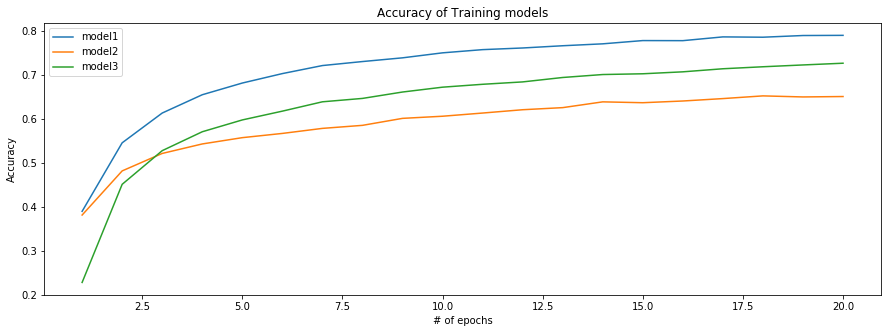

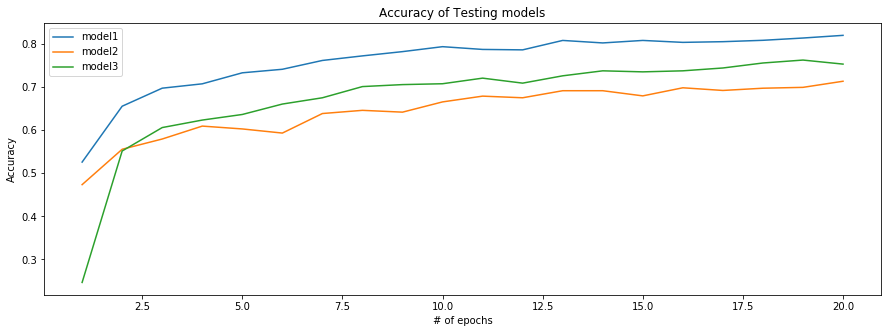

In [31]:
model_1_train = model_1['model'].history.history['acc']
model_1_test = model_1['model'].history.history['val_acc']
model_2_train = model_2['model'].history.history['acc']
model_2_test = model_2['model'].history.history['val_acc']
model_3_train = model_3['model'].history.history['acc']
model_3_test = model_3['model'].history.history['val_acc']
num_of_epochs = 20
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
ax1.set_title("Accuracy of Training models")
ax1.set_xlabel('# of epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(np.arange(1,num_of_epochs+1),model_1_train)
ax1.plot(np.arange(1,num_of_epochs+1),model_2_train)
ax1.plot(np.arange(1,num_of_epochs+1),model_3_train)
ax1.legend(['model1','model2','model3'])
plt.show()

fig = plt.figure(figsize=(15,5))
ax2 = plt.subplot(111)
ax2.set_title("Accuracy of Testing models")
ax2.set_xlabel('# of epochs')
ax2.set_ylabel('Accuracy')
ax2.plot(np.arange(1,num_of_epochs+1),model_1_test)
ax2.plot(np.arange(1,num_of_epochs+1),model_2_test)
ax2.plot(np.arange(1,num_of_epochs+1),model_3_test)
ax2.legend(['model1','model2','model3'])
plt.show()


In [33]:
model_1['model'].save_weights('model_1.h5') 
model_2['model'].save_weights('model_2.h5') 
model_3['model'].save_weights('model_3.h5') 

# Model 1 got a highest accuracy on test data so we'll tune hyperparameter of that model using gridsearchCV from hyperas package

# hyperas require three functions

1 - data()

2 - model() 

3 - optim.minimize()

In [12]:
#Model_1 --> Con->Conv->pool Con->Conv->pool Con->Conv->pool , doubling number of filters
def Model(X_train,Y_train,X_val,Y_val):
    batch_size = 64
    learning_rate=0.001
    num_epochs = 15
    steps_per_epoch = X_train.shape[0] // batch_size
    activation='elu'
    weight_decay = 1e-4
    classes=10
    model = Sequential()
    model_choice = {{choice(['one', 'two'])}}
    if model_choice == 'one':
        model.add(Conv2D(16, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32,32,3)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Conv2D(16, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization()) #Must added before dropout and after activatation except in sigmoid add it before activation
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}})) #choose value between range 0 -1

        model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))

        model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))
    elif model_choice == 'two':
        model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32,32,3)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization()) #Must added before dropout and after activatation except in sigmoid add it before activation
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))

        model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))

        model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout({{uniform(0, 1)}}))

    model.add(Flatten())
    
    model.add(Dense({{choice([256, 512,1024])}}, activation='relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    
    choiceval = {{choice(['one', 'two'])}}
    
    model.add(Dense(classes, activation='softmax'))
    
    
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.rmsprop(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=2,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [13]:
best_run, best_model = optim.minimize(model=Model,
                                      data=load_data,
                                      algo=tpe.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name='Assignment2_v5')

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from keras.preprocessing.image import ImageDataGenerator
except:
    pass

try:
    from keras.datasets import cifar10
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.callbacks import LearningRateScheduler
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Dropout, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
except:
    pass

try:
    from keras.models import Model, load_model
except:
    pass

try:
    from keras.preprocessing import image
except:
    pass

try:
    from keras.utils import layer_utils
except:
    pass

try:
    from keras.utils.data_utils 

  97: 
  0%|                                                                             | 0/10 [00:00<?, ?it/s, best loss: ?]

W1031 06:13:39.354211 13096 deprecation_wrapper.py:119] From c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1031 06:13:39.363972 13096 deprecation_wrapper.py:119] From c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1031 06:13:39.405000 13096 deprecation_wrapper.py:119] From c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1031 06:13:39.406914 13096 deprecation_wrapper.py:119] From c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables ins

Epoch 1/15                                                                                                             
 - 25s - loss: 2.2985 - acc: 0.2806 - val_loss: 1.7442 - val_acc: 0.3840                                               

Epoch 2/15                                                                                                             
 - 21s - loss: 1.6909 - acc: 0.4047 - val_loss: 1.5348 - val_acc: 0.4630                                               

Epoch 3/15                                                                                                             
 - 21s - loss: 1.5569 - acc: 0.4541 - val_loss: 1.4194 - val_acc: 0.5164                                               

Epoch 4/15                                                                                                             
 - 21s - loss: 1.4866 - acc: 0.4885 - val_loss: 1.3816 - val_acc: 0.5300                                               

Epoch 5/15                          

W1031 06:18:55.316885 13096 nn_ops.py:4224] Large dropout rate: 0.966268 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/15                                                                                                             
 - 20s - loss: 3.4623 - acc: 0.1350 - val_loss: 2.4675 - val_acc: 0.1764                                               

Epoch 2/15                                                                                                             
 - 21s - loss: 2.2825 - acc: 0.1998 - val_loss: 2.1150 - val_acc: 0.2268                                               

Epoch 3/15                                                                                                             
 - 20s - loss: 2.0361 - acc: 0.2436 - val_loss: 1.9361 - val_acc: 0.2704                                               

Epoch 4/15                                                                                                             
 - 19s - loss: 1.9319 - acc: 0.2716 - val_loss: 1.8190 - val_acc: 0.3048                                               

Epoch 5/15                          

Epoch 8/15                                                                                                             
 - 20s - loss: 1.5309 - acc: 0.4705 - val_loss: 1.4105 - val_acc: 0.5124                                               

Epoch 9/15                                                                                                             
 - 20s - loss: 1.4909 - acc: 0.4900 - val_loss: 1.3596 - val_acc: 0.5388                                               

Epoch 10/15                                                                                                            
 - 20s - loss: 1.4514 - acc: 0.5072 - val_loss: 1.3400 - val_acc: 0.5546                                               

Epoch 11/15                                                                                                            
 - 20s - loss: 1.4261 - acc: 0.5178 - val_loss: 1.3167 - val_acc: 0.5606                                               

Epoch 12/15                         

Epoch 15/15                                                                                                            
 - 19s - loss: 1.2555 - acc: 0.5680 - val_loss: 1.1257 - val_acc: 0.6108                                               

100%|█████████████████████████████████████████████████████████████| 10/10 [51:00<00:00, 306.10s/it, best loss: -0.7896]


In [19]:
print(best_run)

{'Dropout_3': 0.2283813112902432, 'model_choice': 1, 'Dropout_2': 0.9938985031494777, 'model_choice_1': 1, 'Dropout_4': 0.5422412690636627, 'Dropout_5': 0.33351393608141355, 'Dense': 1, 'Dropout_6': 0.10530729142803252, 'Dropout': 0.4236166283779518, 'Dropout_1': 0.18458586014066036}


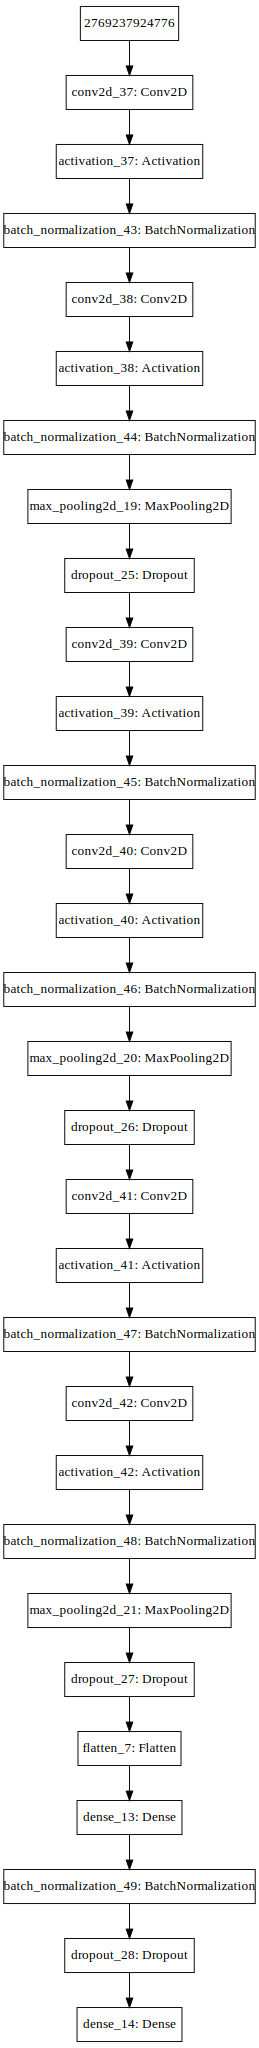

In [23]:
plot_model(best_model, to_file='model.png')
SVG(model_to_dot(best_model).create(prog='dot', format='svg'))

In [22]:
train_acc = best_model.history.history['acc'][-1]
val_acc = best_model.history.history['val_acc'][-1]
train_loss = best_model.history.history['loss'][-1]
val_loss = best_model.history.history['val_loss'][-1]
print("Training Accuracy :",train_acc)
print("Validation Accuracy :",val_acc)
print("Training loss :",train_loss)
print("Validation loss :",val_acc)

Training Accuracy : 0.7659115186042371
Validation Accuracy : 0.7994
Training loss : 0.7931721560340007
Validation loss : 0.7994


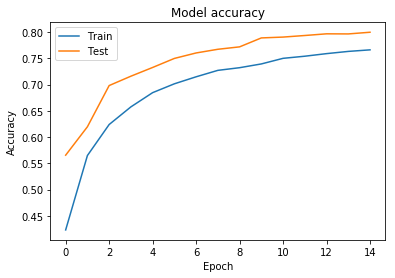

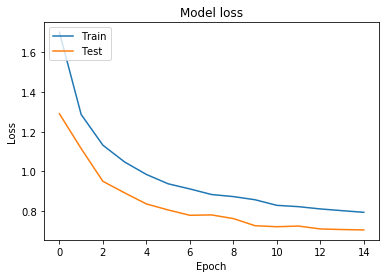

In [25]:
# Plot training & validation accuracy values
plt.plot(best_model.history.history['acc'])
plt.plot(best_model.history.history['val_acc']) #validation accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(best_model.history.history['loss'])
plt.plot(best_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Now we got the best parameters let's use it in the model and run the model for 150 epochs instead of 15 epochs 

In [41]:
#Model_1 --> Con->Conv->pool Con->Conv->pool Con->Conv->pool , doubling number of filters
def MyModel(X_train,Y_train,X_val,Y_val):
    batch_size = 64
    learning_rate=0.001
    num_epochs = 150
    steps_per_epoch = X_train.shape[0] // batch_size
    activation='elu'
    weight_decay = 1e-4
    classes=10
    model = Sequential() 
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(32,32,3)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization()) #Must added before dropout and after activatation except in sigmoid add it before activation
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2283813112902432))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5422412690636627))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.33351393608141355))
    

    model.add(Flatten())    
    model.add(Dense(512))
    model.add(Dropout(0.10530729142803252))
    
    model.add(Dense(classes, activation='softmax'))
    
    
    #data augmentation
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range = 0.20, 
        shear_range = 0.20,
        fill_mode = "nearest"
        )
    datagen.fit(X_train)
    opt_rms = keras.optimizers.rmsprop(lr=learning_rate,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    history = History()
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),\
                            steps_per_epoch=steps_per_epoch,epochs=num_epochs,\
                            verbose=2,validation_data=(X_val,Y_val),callbacks=[history,LearningRateScheduler(data.lr_schedule)])
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [42]:
MyModel = MyModel(X_train,Y_train,X_val,Y_val)

Epoch 1/150
 - 22s - loss: 7.4429 - acc: 0.1982 - val_loss: 2.1233 - val_acc: 0.3342
Epoch 2/150
 - 21s - loss: 2.0388 - acc: 0.3719 - val_loss: 1.9019 - val_acc: 0.4048
Epoch 3/150
 - 23s - loss: 1.9242 - acc: 0.4119 - val_loss: 1.8565 - val_acc: 0.4708
Epoch 4/150
 - 21s - loss: 1.8217 - acc: 0.4460 - val_loss: 1.6439 - val_acc: 0.5068
Epoch 5/150
 - 22s - loss: 1.5850 - acc: 0.4730 - val_loss: 1.3290 - val_acc: 0.5386
Epoch 6/150
 - 22s - loss: 1.4160 - acc: 0.5106 - val_loss: 1.2212 - val_acc: 0.5868
Epoch 7/150
 - 22s - loss: 1.3081 - acc: 0.5477 - val_loss: 1.5383 - val_acc: 0.5644
Epoch 8/150
 - 22s - loss: 1.2687 - acc: 0.5728 - val_loss: 1.0560 - val_acc: 0.6438
Epoch 9/150
 - 21s - loss: 1.1693 - acc: 0.6054 - val_loss: 1.0300 - val_acc: 0.6542
Epoch 10/150
 - 21s - loss: 1.1180 - acc: 0.6262 - val_loss: 1.0193 - val_acc: 0.6598
Epoch 11/150
 - 21s - loss: 1.0794 - acc: 0.6436 - val_loss: 0.9249 - val_acc: 0.7026
Epoch 12/150
 - 21s - loss: 1.0591 - acc: 0.6549 - val_loss: 0.

Epoch 97/150
 - 20s - loss: 0.6180 - acc: 0.8215 - val_loss: 0.5765 - val_acc: 0.8356
Epoch 98/150
 - 20s - loss: 0.6147 - acc: 0.8234 - val_loss: 0.5601 - val_acc: 0.8466
Epoch 99/150
 - 20s - loss: 0.6170 - acc: 0.8221 - val_loss: 0.5715 - val_acc: 0.8414
Epoch 100/150
 - 20s - loss: 0.6194 - acc: 0.8224 - val_loss: 0.5660 - val_acc: 0.8440
Epoch 101/150
 - 20s - loss: 0.6058 - acc: 0.8255 - val_loss: 0.5609 - val_acc: 0.8450
Epoch 102/150
 - 20s - loss: 0.5938 - acc: 0.8296 - val_loss: 0.5433 - val_acc: 0.8532
Epoch 103/150
 - 21s - loss: 0.5822 - acc: 0.8327 - val_loss: 0.5519 - val_acc: 0.8492
Epoch 104/150
 - 20s - loss: 0.5819 - acc: 0.8335 - val_loss: 0.5346 - val_acc: 0.8572
Epoch 105/150
 - 20s - loss: 0.5804 - acc: 0.8323 - val_loss: 0.5433 - val_acc: 0.8518
Epoch 106/150
 - 20s - loss: 0.5749 - acc: 0.8341 - val_loss: 0.5463 - val_acc: 0.8498
Epoch 107/150
 - 20s - loss: 0.5776 - acc: 0.8357 - val_loss: 0.5490 - val_acc: 0.8480
Epoch 108/150
 - 20s - loss: 0.5798 - acc: 0.8

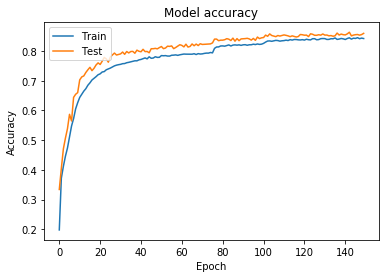

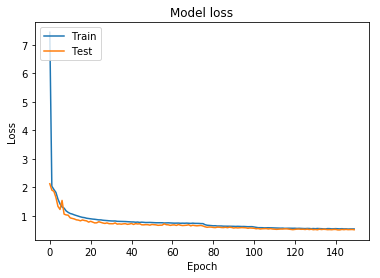

In [44]:
# Plot training & validation accuracy values
plt.plot(MyModel['model'].history.history['acc'])
plt.plot(MyModel['model'].history.history['val_acc']) #validation accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(MyModel['model'].history.history['loss'])
plt.plot(MyModel['model'].history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
#Save Model
model_json = MyModel['model'].to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
MyModel['model'].save_weights('model.h5') 

In [46]:
#test Model
preds = MyModel['model'].evaluate(X_test, Y_test,batch_size=128, verbose=1)

10000/10000 [==============================] - ETA: 10 - ETA: 3 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 173us/step


In [47]:
print ("Testing Accuracy = " + str(preds[1]))
print ("Testing Loss = " + str(preds[0]))

Testing Accuracy = 0.856
Testing Loss = 0.5095445983886718


In [16]:
MyModel['model'].load_weights('model.h5')

c:\users\muata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


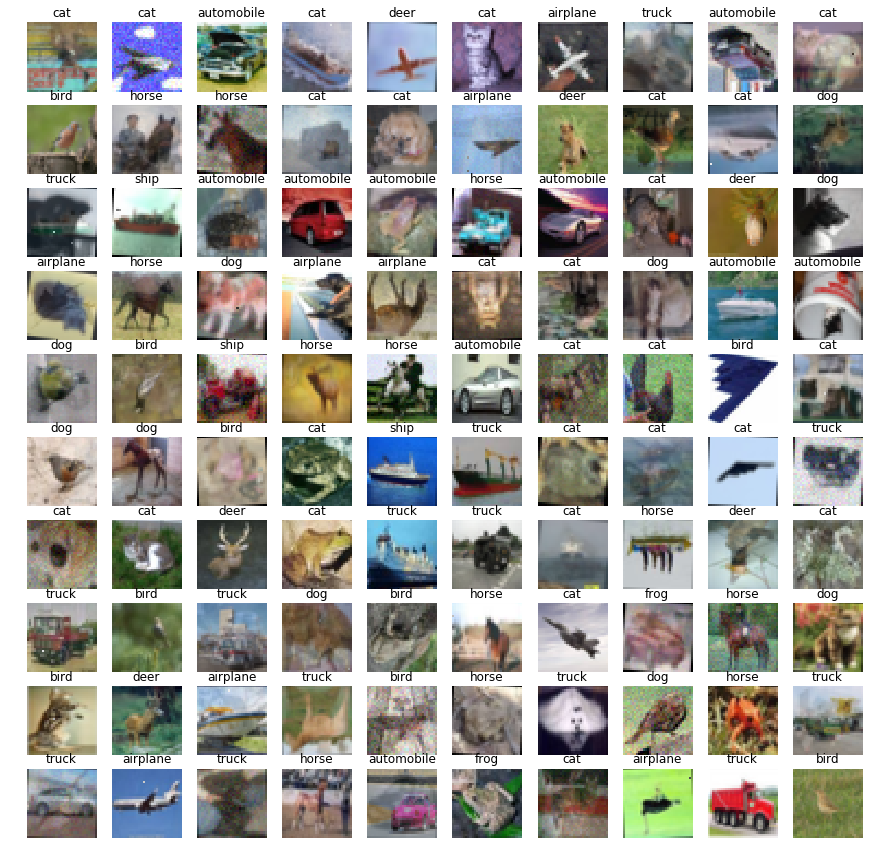

In [54]:
plt.figure(figsize=(15,15))
for i in range(1,101):
    img_path = 'images/' + str(i) + '.png'
    img = image.load_img(img_path, target_size=(32, 32))
   
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    prediction = MyModel['model'].predict(x)[0]
    class_name = classes[np.where(prediction == np.max(prediction))[0][0]]
    my_image = scipy.misc.imread(img_path)
    plt.subplot(10,10,i)
    plt.axis('off')
    plt.title(class_name)
    plt.imshow(my_image)
